# Classificando o Breast Cancer Wisconsin Dataset 

## 1. Lendo the Breast Cancer Wisconsin dataset


In [7]:
import pandas as pd
import numpy as np

# df = pd.read_csv('https://archive.ics.uci.edu/ml/'
#                 'machine-learning-databases'
#                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df = pd.read_csv('data/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
df.shape

(569, 32)

In [9]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [10]:
le.transform(['M', 'B'])

array([1, 0])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

## 2. Combinando Transformadores e Estimadores em uma Pipeline

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


## 3. Usando Validação Cruzada de K-Fold para evaluar o desempenho do modelo (model performance)

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.93478261  0.93478261  0.95652174  0.95652174  0.93478261  0.95555556
  0.97777778  0.93333333  0.95555556  0.95555556]
CV accuracy: 0.950 +/- 0.014


## 4. Diagnóstico de problemas de bias e variância usando curvas de aprendizagem (learning curves)

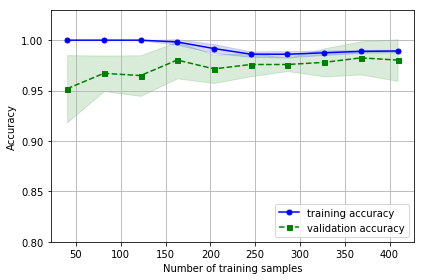

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('learning_curves.png', dpi=300)
plt.show()

## 5. Lidando com overfitting e underfitting usando curvas de validação (validation curves)

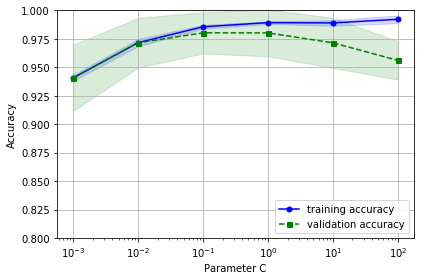

In [15]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('validation_curve.png', dpi=300)
plt.show()

## 6. Fine-Tuning Hyperparâmetros com Grid Search

Lembre-se de que anteriormente codificamos os rótulos das classes para que as amostras malignas sejam a classe "positiva" (1), e as amostras benignas são a classe "negativa" (0):

### 6.1 Usando SVC como estimador com CV = 10

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.984615384615
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


### 6.2 Usando SVC como estimador com CV = 2

In [17]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015


### 6.3 Usando uma Decision Tree como estimador com CV = 5

In [20]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.934 +/- 0.016


## 7. Otimizando a Precisão e o Recall de um Modelo de Classificação

In [18]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [20]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.986202145696
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
